# Practical 2

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.
Let's start with a bit of exploration.

### Tasks 1.1: Dataset Exploration 
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

# checking whether there are any observations that have NAs
# in a second step exclude the observations.
idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

In [4]:
print("There are",df.shape[0],"observations and",df.shape[1],"features")

# labels of dataframe
print("there are",len((df.columns.values)),"labels in the dataframe.")

# range of predictors
min_max = []
for jj in range(0,df.shape[1]):
    if(df.dtypes[jj] == float):
        min_max.append((df.columns.values[jj],min(df.iloc[:,jj]),max(df.iloc[:,jj])))
min_max

There are 1080 observations and 82 features
there are 82 labels in the dataframe.


[('DYRK1A_N', 0.145326504, 2.516367377),
 ('ITSN1_N', 0.245358515, 2.602662135),
 ('BDNF_N', 0.11518140199999999, 0.497159859),
 ('NR1_N', 1.330830671, 3.7576413310000003),
 ('NR2A_N', 1.737539936, 8.482553422),
 ('pAKT_N', 0.063236006, 0.5390501320000001),
 ('pBRAF_N', 0.064042588, 0.317065589),
 ('pCAMKII_N', 1.343998185, 7.4640702139999995),
 ('pCREB_N', 0.112811791, 0.306247231),
 ('pELK_N', 0.42903225799999994, 6.113347458),
 ('pERK_N', 0.149155227, 3.566685372),
 ('pJNK_N', 0.05211039, 0.493425858),
 ('PKCA_N', 0.191430693, 0.473992025),
 ('pMEK_N', 0.056818182, 0.45800055100000003),
 ('pNR1_N', 0.500159744, 1.4081687859999998),
 ('pNR2A_N', 0.281284812, 1.412750248),
 ('pNR2B_N', 0.301608579, 2.723965377),
 ('pPKCAB_N', 0.567840497, 3.0613871460000004),
 ('pRSK_N', 0.09594155800000001, 0.6509618070000001),
 ('AKT_N', 0.06442119, 1.182174736),
 ('BRAF_N', 0.143893591, 2.133415747),
 ('CAMKII_N', 0.212959525, 0.586244541),
 ('CREB_N', 0.113636364, 0.319558247),
 ('ELK_N', 0.497695

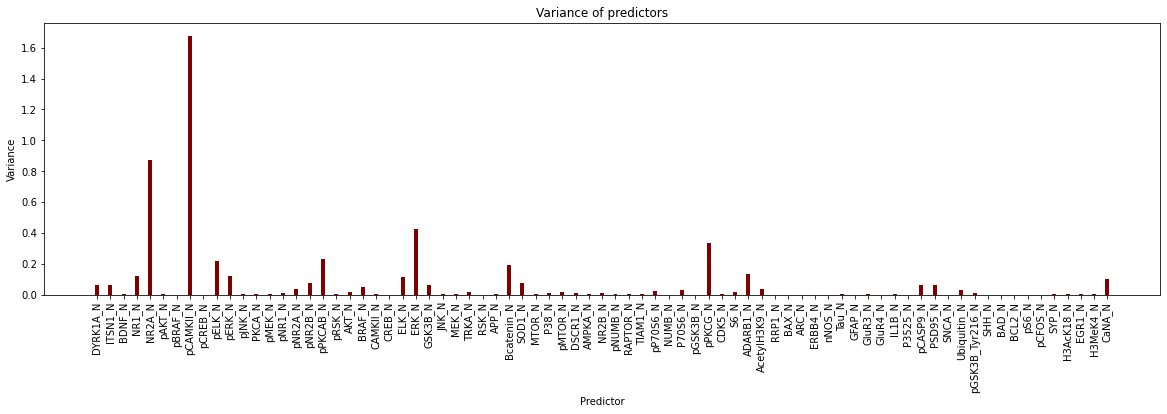

In [5]:
# variance for each predictor
var = df.var()
fig = plt.figure(figsize = (20, 5))
plt.bar(var.index.values,var,color = "maroon", width = .3)
plt.xticks(rotation = 90)
plt.title("Variance of predictors")
plt.xlabel("Predictor")
plt.ylabel("Variance")
plt.show()


**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [6]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)
    
    n_train = round(frac * X.shape[0])
    n_test = X.shape[0] - n_train
    
    # using the first n_train shuffled indexes for the training set
    # and the following observations for the training set
    idx_train = idx_shuffled[:n_train]
    idx_test = idx_shuffled[n_train:n_train + n_test]
    
    X_train = X[idx_train,:]
    X_test = X[idx_test,:]
    
    y_train = y[idx_train]
    y_test = y[idx_test]
    
    return X_train, y_train, X_test, y_test

def preprocess(X):
    X_norm = X.copy()
    for jj in range(0,X_norm.shape[1]):
        mean = np.mean(X_norm[:,jj])
        sd = np.std(X_norm[:,jj])
        
        X_norm[:,jj] = (X_norm[:,jj] - mean)/sd 
    return X_norm

In [7]:
# apply functions
X_train, y_train, X_test, y_test = split_data(X_all,t_all,frac = 0.3, seed = 2903)

X_train_norm = preprocess(X_train)
X_test_norm = preprocess(X_test)

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

** Task 2.1 ***

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

In [8]:
# create the lda weights function
def compute_lda_weights(x,y):
    
    # assign each observation to one class
    X_1 = x[y == True,]
    X_2 = x[y == False,]
    
    # compute means within each class
    m_1 = np.mean(X_1,axis = 0)
    m_2 = np.mean(X_2,axis = 0)
    
    # compute the variances
    def get_s(X,m):
        s = 0
        for jj in range(0,X.shape[0]):
            aux = X[jj] - m
            s = s + np.matmul(aux,aux.T)
        return s
    s_1 = get_s(X_1,m_1)
    s_2 = get_s(X_2,m_2)
    S = s_1 + s_2
    
    # compute weights
    w = 1/S * (m_2 - m_1)
    
    return m_1, m_2, w

m_0, m_1, w_lda = compute_lda_weights(X_train_norm,y_train)

Text(0.5, 0, 'predictors')

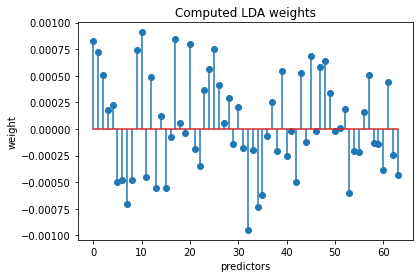

In [9]:
# X, X_test, t, t_test = split_data(X_all, t_all, seed=1)
# m0, m1, mdiff, w_lda = compute_lda_weights(X, t)

plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

In [10]:
np.matmul(X_train_norm,w_lda)

array([-0.00640793,  0.0226337 , -0.00925348, -0.0107875 , -0.01123481,
       -0.01633246,  0.01787976, -0.01514223, -0.01053381,  0.00957232,
       -0.01079068, -0.01213274,  0.00589533,  0.01178769, -0.00483032,
        0.02016737, -0.01575427, -0.01169277, -0.01232966,  0.00547153,
       -0.0025644 ,  0.00552634,  0.01306161, -0.01869918, -0.0012523 ,
        0.00674953,  0.02443153,  0.01853401, -0.00947503, -0.00754025,
        0.01279192,  0.01225119])

### Task 2.3

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

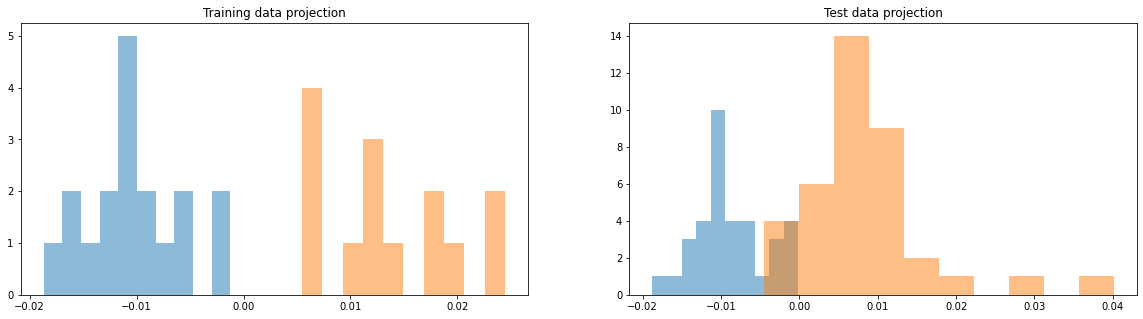

In [11]:
a,b = np.matmul(X_train_norm[y_train],w_lda), np.matmul(X_train_norm[~y_train],w_lda)
c,d = np.matmul(X_test_norm[y_test],w_lda), np.matmul(X_test_norm[~y_test],w_lda)
fig, ax = plt.subplots(1,2,figsize = (20,5))

ax[0].hist(a ,label='class 0',alpha=0.5)
ax[0].hist(b ,label='class 1',alpha=0.5)
ax[0].set_title("Training data projection")

ax[1].hist(c ,label='class 0',alpha=0.5)
ax[1].hist(d ,label='class 1',alpha=0.5)
ax[1].set_title("Test data projection")

plt.show()

### Task 2.4 

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [12]:
c_ = np.matmul(w_lda.T, 0.5 * (m_0 + m_1))
print("threshold c =", c_)



threshold c = 0.0014821732139192845


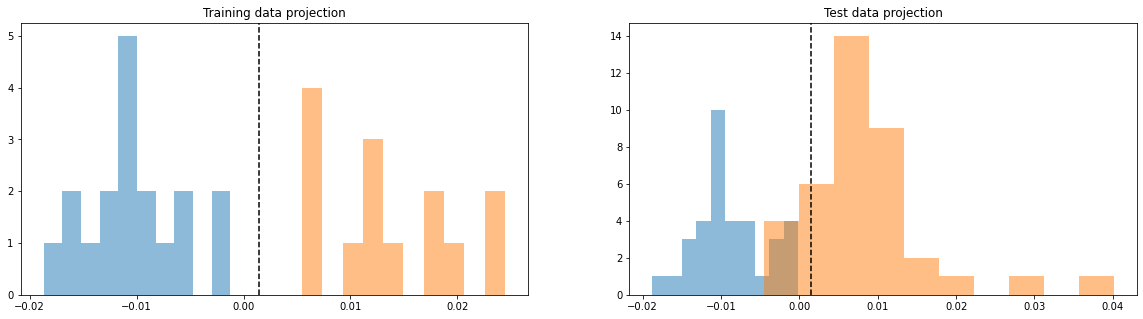

In [13]:
a,b = np.matmul(X_train_norm[y_train],w_lda), np.matmul(X_train_norm[~y_train],w_lda)
c,d = np.matmul(X_test_norm[y_test],w_lda), np.matmul(X_test_norm[~y_test],w_lda)
fig, ax = plt.subplots(1,2,figsize = (20,5))

ax[0].hist(a ,label='class 0',alpha=0.5)
ax[0].hist(b ,label='class 1',alpha=0.5)
ax[0].set_title("Training data projection")
ax[0].axvline(x = c_, color = "black", linestyle = "dashed")

ax[1].hist(c ,label='class 0',alpha=0.5)
ax[1].hist(d ,label='class 1',alpha=0.5)
ax[1].set_title("Test data projection")
ax[1].axvline(x = c_, color = "black", linestyle = "dashed")

plt.show()

In [73]:
# Determine accuracy of discriminant on training and test set:
pred_train = np.matmul(X_train_norm,w_lda) <= c_
pred_test = np.matmul(X_test_norm,w_lda) <= c_
wrong_train = pred_train != y_train
wrong_test = pred_test != y_test

dt_train = pd.DataFrame({'predictions': pred_train,
                         'observed': y_train,
                        })
dt_test = pd.DataFrame({'predictions': pred_test,'observed': y_test})

miss_train = sum(wrong_train)/len(wrong_train)
miss_test = sum(wrong_test)/len(wrong_test)

print("confusion matrix training set:")
print(pd.crosstab(dt_train.predictions,dt_train.observed))
print("confusion matrix test set:")
print(pd.crosstab(dt_test.predictions,dt_test.observed))
print("missclassification rate on the training set:",miss_train*100,"%",
     "missclassification rate on the test set:",round(miss_test*100,2),"%")

confusion matrix training set:
observed     False  True 
predictions              
False           14      0
True             0     18
confusion matrix test set:
observed     False  True 
predictions              
False           33      0
True             5     35
missclassification rate on the training set: 0.0 % missclassification rate on the test set: 6.85 %


## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [75]:
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
import pickle

X_all, t_all = pickle.load(open('data/cnn_features.pickle', 'rb'))

**Task 3.0: Normalize the data**

Make sure the data has has zero mean and variance 1 per feature.

In [76]:
X_all_norm = preprocess(X_all)

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  
Hints:  
(a) There is a bias term in logistic regression  
(b) Use a small value for weight init to avoid numerical problems.

2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [109]:
from math import exp

def sigmoid(a):
    out = np.zeros(len(a))
    for jj in range(0,len(a)):
        out[jj] = exp(a[jj]) / (1+exp(a[jj]))
    return out

def get_y(X,w):
    return sigmoid(X.dot(w))

def get_R(y):
    R = np.identity(y.size)
    R = R*(y*(1-y))
    return R

def irls(X, t): 
    w = np.zeros(X.shape[1])
    y = get_y(X,w)
    R = get_R(y)
    z = X.dot(w) - np.matmul(np.linalg.inv(R),y-t)
    
    X_R_X = np.matmul(np.matmul(X.T,R),X)
    update = np.linalg.inv(X_R_X).dot(X.T.dot(y-t))
    
    while(any(update > 0.001)):
        w = w - update
        y = get_y(X,w)
        R = get_R(y)
        z = X.dot(w) - np.matmul(np.linalg.inv(R),y-t)
        X_R_X = np.matmul(np.matmul(X.T,R),X)
        update = np.linalg.inv(X_R_X).dot(X.T.dot(y-t))
    
    return w

In [110]:
# apply function to the data
w = irls(X_all_norm,t_all)

preds = pd.DataFrame({'probabilities': get_y(X_all_norm,w),
                      'class': (get_y(X_all_norm,w) > 0.5).astype(int)})

LinAlgError: Singular matrix

In [108]:
# accuracy
preds



,probabilities,class
0,2.440126,1
1,2.932255,1
2,1.667975,1
3,3.171635,1
4,1.442858,1
...,...,...
1995,2.462000,1
1996,2.986725,1
1997,1.624222,1
1998,2.321589,1


**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [13]:
from matplotlib import pyplot as plt

In [14]:
# regplot = [None, None, None]
# l1_plot, = plt.plot(np.linspace(0.02, 1, 25), scores['l1'], '-o')
# l1_plot.set_label('l1')
# l2_plot, = plt.plot(np.linspace(0.02, 1, 25), scores['l2'], '-o')
# l2_plot.set_label('l2')
# noreg_plot, = plt.plot(np.linspace(0.02, 1, 25), [score_noreg]*25, '-o')
# noreg_plot.set_label('noreg')
# plt.legend()
# plt.show()